<a href="https://colab.research.google.com/github/taavip/PLANK/blob/main/plank_statistika_kvaliteedi_analyys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install owslib geopandas pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 14.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import geopandas as gpd
import requests
from owslib.wfs import WebFeatureService
from concurrent.futures import ThreadPoolExecutor, as_completed
import math

# WFS teenuse URL
url = 'https://planeeringud.ee/plank/wfs?'

# Loome ühenduse WFS teenusega
wfs = WebFeatureService(url=url, version="2.0.0")

# Loeme kõik saadaval olevad kihid teenuses
layers = list(wfs.contents)

# Kuvame kõik saadaval olevad kihid
print("Saadaval kihid WFS teenuses:")
for layer in layers:
    print(layer)

# Funktsioon, mis laadib kihi andmed WFS teenusest
def load_layer_data(layer_name):
    print(f"\nLaen kihti: {layer_name}")  # Kuvame, millist kihti hetkel laeme

    # Määrame päringu parameetrid
    params = dict(service='WFS', version="2.0.0", request='GetFeature',
                  typeNames=layer_name, startIndex=0, count=1000, outputFormat='text/xml; subtype=gml/3.2.1')

    all_gdf = []
    page = 0

    while True:
        # Arvutame startIndex järgmisele lehele
        params['startIndex'] = page * 1000

        # Koostame päringu URL
        wfs_request_url = requests.Request('GET', url, params=params).prepare().url
        response = requests.get(wfs_request_url)

        # Laeme andmed GeoPandasiga
        try:
            gdf = gpd.read_file(wfs_request_url)
            all_gdf.append(gdf)

            # Kui tagastati vähem kui 1000 kirjet, lõpetame
            if len(gdf) < 1000:
                break

            # Jätkame järgmise lehega
            page += 1

        except Exception as e:
            print(f"Viga kihi {layer_name} laadimisel lehelt {page + 1}: {e}")
            break

    # Ühendame kõik lehed üheks GeoDataFrame'iks
    if all_gdf:
        combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdf, ignore_index=True))
        return combined_gdf
    else:
        print(f"Ei leitud andmeid kihil {layer_name}.")
        return None

# Lae kõik kihid paralleelselt
def load_all_layers_parallel(layers):
    gdfs = {}
    with ThreadPoolExecutor(max_workers=8) as executor:  # Tõstetud töötlejate arv
        # Laadime kõik kihid paralleelselt ja kogume tulemusi
        futures = {executor.submit(load_layer_data, layer): layer for layer in layers}

        for future in as_completed(futures):
            layer = futures[future]
            try:
                gdf = future.result()
                if gdf is not None:
                    gdfs[layer] = gdf
                    print(f"Kihil {layer} on {len(gdf)} rida andmeid.")
            except Exception as e:
                print(f"Kihi {layer} laadimisel tekkis viga: {e}")

    return gdfs

# Laeme kõik kihid paralleelselt (nt võtame ainult esimese 10 kihi)
gdfs = load_all_layers_parallel(layers[38:39])

# Kontrollime tulemusi
print(f"Leitud GeoDataFrame'id: {len(gdfs)}")
for layer_name, gdf in gdfs.items():
    print(f"Kihi {layer_name} veerud: {gdf.columns}")


Saadaval kihid WFS teenuses:
plank:yrpmsp
plank:yrpmsp_kihid
plank:yrpmsp_kihid_2
plank:yrpmsp_kihid_1
plank:maakonnaplaneeringu_ala
plank:mp_msp
plank:mp_msp_2
plank:mp_msp_1
plank:mp_tuuleala
plank:mp_vesiviljelus
plank:mp_rohev
plank:mp_toimepiirkond
plank:mp_linnaline
plank:mp_suunis
plank:mp_suunis_2
plank:mp_suunis_1
plank:mp_vaartala
plank:mp_vaartala_2
plank:mp_vaartala_1
plank:mp_taristu
plank:mp_taristu_2
plank:mp_taristu_1
plank:mp_keskus
plank:yldplaneeringud
plank:yp_tiheasustus
plank:yp_maakasutus
plank:yp_dpkoko
plank:yp_ekv
plank:yp_ekv_1
plank:yp_tingimus
plank:yp_tingimus_2
plank:yp_tingimus_1
plank:yp_ehitis
plank:yp_ehitis_2
plank:yp_ehitis_1
plank:yp_transport_3
plank:yp_transport
plank:yp_transport_1
plank:detailplaneering
plank:dp_krunt
plank:dp_hoonestus
plank:dp_tingimus
plank:dp_tingimus_2
plank:dp_tingimus_1
plank:dp_transp_3
plank:dp_transp
plank:dp_transp_1
plank:dp_tehno_3
plank:dp_tehno
plank:dp_tehno_1
plank:kep_ala
plank:kep_krunt
plank:kep_hoonestus
pl

In [ ]:
gdfs['plank:detailplaneering'].dtypes

,0
gml_id,object
lowerCorner,object
upperCorner,object
sysid,int32
planid,float64
kovid,object
plannim,object
korraldaja,object
planseis_nimi,object
planksh,object


In [ ]:
gdfs['plank:detailplaneering']['vastuvkp|timePosition'] = pd.to_datetime(gdfs['plank:detailplaneering']['vastuvkp|timePosition'])
gdfs['plank:detailplaneering']['kehtestkp|timePosition'] = pd.to_datetime(gdfs['plank:detailplaneering']['kehtestkp|timePosition'])

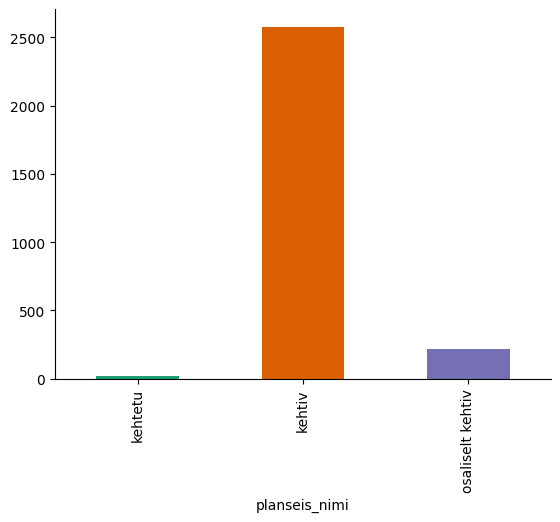

In [ ]:
# @title planseis_nimi

from matplotlib import pyplot as plt
import seaborn as sns
gdf.groupby('planseis_nimi').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)